Group members:


-   Ceccon Gioele - 2079425
-   Nardella Gaia - 2091413
-   Renna Pietro - 2089068
-   Rocca Valerio - 2094861



# Imports

In [ ]:
from xml.dom import pulldom
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.metrics import accuracy_score
import time 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from imblearn.under_sampling import RandomUnderSampler

# Part 1

## Point Generation

We decided to generate 8000 points: 


1.   4000 belong to class 1 
2.   4000 belong to class -1

In total, only 5% of the samples (equally divided among the two classes) have their true labeled assigned. 



In [ ]:
random.seed(1)
n_points = 8000

In [ ]:
def generate_points(n_points=n_points, weights = [0.25, 0.25, 0.25, 0.25]):
    # Define the means and covariance matrices for the four clusters
    cluster_params = [
        {
            'mean': np.array([-2, 0]),
            'cov': np.array([[7, 0], [0, 0.5]])
        },
        {
            'mean': np.array([2, 4]),
            'cov': np.array([[0.5, 0], [0, 4]])
        },
        {
            'mean': np.array([2, 11]),
            'cov': np.array([[7, 0], [0, 0.5]])
        },
        {
            'mean': np.array([-2, 7]),
            'cov': np.array([[0.5, 0], [0, 4]])
        }
    ]

    samples = np.empty((0, 3))

    
    for i, cluster in enumerate(cluster_params):
        
        sample = np.random.multivariate_normal(cluster['mean'], cluster['cov'], int(n_points*weights[i]))

        # If the points are from the firste two clusters, assign label 1
        # Otherwise, assign label -1
        if i==0 or i==1:
            label=1
        elif i==2 or i==3:
            label =-1
        
        # np.full() is a NumPy function that creates a new array of a specified shape and fills it with a given scalar value (label)
        # The axis=1 argument tells np.concatenate() to concatenate the arrays horizontally (i.e., by adding columns), so that the label
        # column is added to the right of the sample array.
        sample = np.concatenate((sample, np.full((sample.shape[0], 1), label)), axis=1)
        
        samples = np.concatenate((samples, sample))
    
    true_unlabel = np.array([])

    for i in range(len(samples)):
        # after 19 points I get a labeled point, I set label equal to zero in other points (we know label of only 5% of points)
        if i % 20 != 0.0:
            true_unlabel = np.append(true_unlabel, samples[i][2])
            samples[i][2] = 0

    # Split the samples based on their class label
    unlabeled = samples[samples[:, 2] == 0]
    class1= samples[samples[:, 2] == 1]
    class2 = samples[samples[:, 2] == -1]
    labeled = np.concatenate((class1,class2))

    return unlabeled, class1, class2, labeled, true_unlabel  # a tuple

In [ ]:
samples = generate_points()
unlabeled_samples = samples[0]
class1_samples = samples[1]
class2_samples = samples[2]
labeled_samples = samples[3]
true_unlabeled_samples = samples[4]

print(f"There are 1000 points where {class1_samples.shape[0]} belong to class 1 and {class1_samples.shape[0]} belong to class -1. {unlabeled_samples.shape[0]} samples are unlabeled and {labeled_samples.shape[0]} are labeled ({np.round(((labeled_samples.shape[0]/n_points)*100),1)}% of the total.)")

There are 1000 points where 200 belong to class 1 and 200 belong to class -1. 7600 samples are unlabeled and 400 are labeled (5.0% of the total.)


In [ ]:
# CREATION OF THE INDEX OF THE COLUMN OF THE LABELS
index_lab = 2

In [ ]:
def generate_random_labels(unlabeled, ind_lab):
    # Assign random label to unlabeled units

    random_labels=np.random.choice([-1, 1], size=np.shape(unlabeled)[0], p=[0.5, 0.5])
    random_labels_samples = np.concatenate((unlabeled[:,0:(ind_lab)], np.reshape(random_labels, (-1, 1))), axis=1)

    return random_labels_samples

In [ ]:
random_unlabeled_samples = generate_random_labels(unlabeled_samples, index_lab)

print(f"First labels initialization: {random_unlabeled_samples}")

First labels initialization: [[-5.22474136  0.3431846   1.        ]
 [ 0.26591711 -0.75925521  1.        ]
 [-4.43875224 -0.14824563 -1.        ]
 ...
 [-0.63407993  7.45697703  1.        ]
 [-2.97218376  6.27218179 -1.        ]
 [-1.21445851  8.21974421 -1.        ]]


In [ ]:
def plot_points(unlabeled_samples, class1_samples, class2_samples):
    # Plot the samples of each class with a different color and marker
    plt.scatter(unlabeled_samples[:, 0], unlabeled_samples[:, 1], color='grey', label='Unlabeled', alpha=0.7)
    plt.scatter(class1_samples[:, 0], class1_samples[:, 1], color='red', label='Label 1', alpha=0.7)
    plt.scatter(class2_samples[:, 0], class2_samples[:, 1], color='blue', label='Label -1', alpha=0.7)

    # Add legend and axis labels
    plt.legend()
    plt.xlabel('X_1')
    plt.ylabel('X_2')

    # Show the plot
    plt.show()

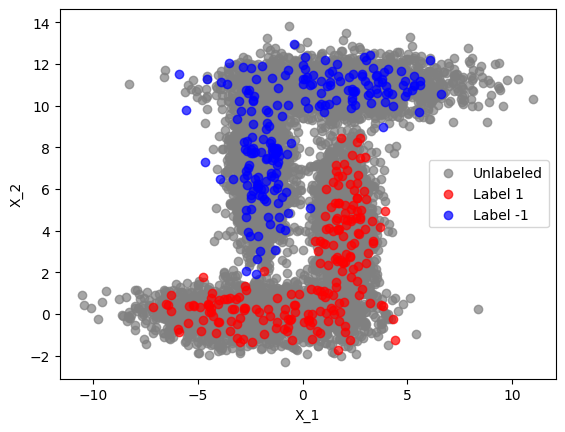

In [ ]:
plot_points(unlabeled_samples, class1_samples, class2_samples)

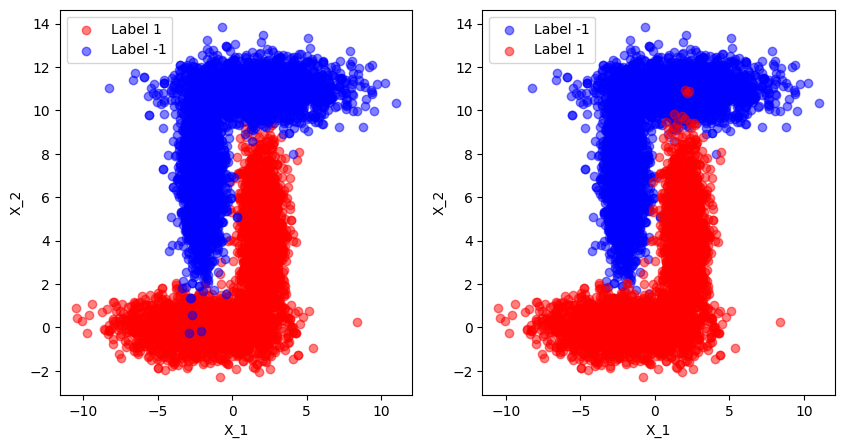

In [ ]:
true_samples = np.concatenate((labeled_samples,unlabeled_samples))

k = 0
for i in range(len(true_samples)):
  if true_samples[i,2] == 0:
    true_samples[i,2] = true_unlabeled_samples[k]
    k += 1

positive = true_samples[(true_samples[:, 2] == 1)]  # matrix with unlab samples having true lab 1
negative = true_samples[(true_samples[:, 2] == -1)] # matrix with unlab samples having true lab -1

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Plot 1: positive and negative samples
ax1.scatter(positive[:, 0], positive[:, 1], color='red', alpha=0.5)
ax1.scatter(class1_samples[:, 0], class1_samples[:, 1], color='red', label='Label 1', alpha=0.5)
ax1.scatter(class2_samples[:, 0], class2_samples[:, 1], color='blue', label='Label -1', alpha=0.5)
ax1.scatter(negative[:, 0], negative[:, 1], color='blue', alpha=0.5)

ax1.legend()
ax1.set_xlabel('X_1')
ax1.set_ylabel('X_2')

# Plot 2: negative and positive samples
ax2.scatter(class2_samples[:, 0], class2_samples[:, 1], color='blue', label='Label -1', alpha=0.5)
ax2.scatter(negative[:, 0], negative[:, 1], color='blue', alpha=0.5)
ax2.scatter(positive[:, 0], positive[:, 1], color='red', alpha=0.5)
ax2.scatter(class1_samples[:, 0], class1_samples[:, 1], color='red', label='Label 1', alpha=0.5)

ax2.legend()
ax2.set_xlabel('X_1')
ax2.set_ylabel('X_2')

# Show the plot
plt.show()

## Similarity function and weights computation

In [ ]:
def laplacian_kernel(p1, p2, sigma=0.02):
    # Compute the Euclidean distance between the points
    dist = np.sqrt(np.sum((p1 - p2) ** 2))

    # Compute the Laplacian Kernel
    kernel = np.exp(-dist**2 / sigma)

    return kernel

In [ ]:
# similarity matrix unlabeled-labeled
def similarity_matrix(unlabeled, labeled, ind_lab):

  W = np.zeros((np.shape(unlabeled)[0], np.shape(labeled)[0]))
  W_bar = np.zeros((np.shape(unlabeled)[0], np.shape(unlabeled)[0]))

  # similarity matrix unlabeled-labeled
  for row in range(np.shape(W)[0]):
      for col in range(np.shape(W)[1]): 
          W[row, col] = laplacian_kernel(unlabeled[row, :ind_lab],labeled[col, :ind_lab])

  # similarity matrix unlabeled-unlabeled
  for row in range(np.shape(W_bar)[0]):
      for col in range(np.shape(W_bar)[1]):
          W_bar[row, col] = laplacian_kernel(unlabeled[row, :ind_lab],unlabeled[col, :ind_lab])

  return W, W_bar

In [ ]:
weights = similarity_matrix(unlabeled_samples, labeled_samples, index_lab)
w=weights[0]
w_bar=weights[1]

## Lipschitz constant

If f is twice continuously differentiable, then the Lipschitz constant can be estimated as the maximum eigenvalue of the Hessian matrix $\nabla^2 f$ at any point in the domain of f. Specifically, the Lipschitz constant L is given by:
$$ L = \|\nabla^2 f(x)\| $$

Thus, we can use the maximum eigenvalue of $\nabla^2 f$ to estimate L.

In [ ]:
def compute_L(u_samples, w=w, w_bar=w_bar):
  dim = np.shape(u_samples)[0]
  h = np.zeros((dim,dim))

  for i in range(dim):
    for j in range(dim):
      if i == j:
        h[i,i] = 2 * (np.sum(w[i,:]) + np.sum(w_bar[i,:]) - w_bar[i,i])
      if i != j:
        h[i,j] = 2 * (-np.sum(w_bar[i,j]))

  eigenvalues = np.linalg.eigvals(h)
  return np.max(np.abs(eigenvalues))

In [ ]:
L = compute_L(unlabeled_samples)
print(L)

38.45579179824081


## Gradient Methods

First of all we define some constants and functions that will be used by the algorithms:

In [ ]:
epsilon = 1e-5      # Threshold for the stopping condition
epochs = 50         # Max number of iterations
check = 3           # Used to retrieve informations about the behavior of the algorithm every check iterations

In [ ]:
# Threshold selector
def threshold_sel(y_lab_norm):
    y_lab_out = np.copy(y_lab_norm)
    y_lab_out[y_lab_out < 0] = -1
    y_lab_out[y_lab_out >= 0] = 1
    
    return y_lab_out

In [ ]:
# Accuracy function
def get_accuracy(y):
  y_out = threshold_sel(y)

  return accuracy_score(true_unlabeled_samples, y_out)

In [ ]:
# Plot the missclassified and correctly classified units
def miss_plot(unlab_grad, unlab_samples = unlabeled_samples, unlab_true = true_unlabeled_samples):
  # Output labels
  unlab_labs = threshold_sel(unlab_grad)
  
  # Split in two matrices to plot
  for i in range(np.shape(unlab_samples)[0]):
    unlab_samples[i,2] = unlab_labs[i]
  unlab_true = np.array(unlab_true)

  unlab_samples_tp = unlab_samples[(unlab_samples[:, 2] == 1) & (unlab_samples[:, 2] == unlab_true)]
  unlab_samples_tn = unlab_samples[(unlab_samples[:, 2] == -1) & (unlab_samples[:, 2] == unlab_true)]
  unlab_samples_fp = unlab_samples[(unlab_samples[:, 2] == 1) & (unlab_samples[:, 2] != unlab_true)]
  unlab_samples_fn = unlab_samples[(unlab_samples[:, 2] == -1) & (unlab_samples[:, 2] != unlab_true)]
  
  # Plot the samples of each class with a different color and marker
  plt.scatter(unlab_samples_tp[:, 0], unlab_samples_tp[:, 1], color='red', label='True 1', alpha=0.7)
  plt.scatter(unlab_samples_tn[:, 0], unlab_samples_tn[:, 1], color='blue', label='True -1', alpha=0.7)
  plt.scatter(unlab_samples_fp[:, 0], unlab_samples_fp[:, 1], color='orange', label='False 1', alpha=0.7)
  plt.scatter(unlab_samples_fn[:, 0], unlab_samples_fn[:, 1], color='cyan', label='False -1', alpha=0.7)

  # Add legend and axis labels
  plt.legend()
  plt.xlabel('X_1')
  plt.ylabel('X_2')

  # Show the plot
  return(plt.show())


In [ ]:
# Plot accuracy vs time for all the 3 algorithms
def acc_time_plot_global(result_list_gd, time_list_gd, result_list_rand, time_list_rand, result_list_gs, time_list_gs):
  plt.plot(time_list_gd, result_list_gd, marker = ".", label = "Classic GD")
  plt.plot(time_list_rand, result_list_rand, marker = ".", label = "Randomized BCGD")
  plt.plot(time_list_gs, result_list_gs, marker = ".", label = "G-S BCGD")

  # Set the plot title and labels
  plt.title('Accuracy vs Time')
  plt.xlabel('Elapsed Time (seconds)')
  plt.ylabel('Accuracy')
  plt.legend()

In [ ]:
# Plot accuracy vs epochs
def acc_epochs_plot(result_list, check=check):

  epochs_array = np.arange(0, check * len(result_list), check)
  
  plt.plot(epochs_array, result_list, marker = ".")

  # Set the plot title and labels
  plt.title('Accuracy vs Epochs')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')

In [ ]:
# Plot accuracy vs time
def acc_time_plot(result_list, time_list):
  plt.plot(time_list, result_list, marker = ".")

  # Set the plot title and labels
  plt.title('Accuracy vs Time')
  plt.xlabel('Elapsed Time (seconds)')
  plt.ylabel('Accuracy')


### Gradient Descent

In [ ]:
def gradient(lab_samples, unlab_samples, ind_lab, w=w, w_bar=w_bar):
    grads = []
    for j in range(np.shape(unlab_samples)[0]):
        grad = 0
        for i in range(np.shape(lab_samples)[0]):
            grad += w[j][i] * (unlab_samples[j][ind_lab] - lab_samples[i][ind_lab])
        for i in range(np.shape(unlab_samples)[0]):
            grad += w_bar[j][i] * (unlab_samples[j][ind_lab] - unlab_samples[i][ind_lab])
        grads.append(2 * grad)

    return np.array(grads)

In [ ]:
def gradient_descent(lab_samples, unlab_samples, ind_lab, alpha=1/L, epochs=epochs, epsilon=epsilon, check=check):
    y_lab = np.copy(unlab_samples)

    acc_list = []
    time_list = []

    start_time = time.process_time()

    for i in range(epochs):
        grads = gradient(lab_samples, y_lab, ind_lab, w, w_bar)

        norm = np.linalg.norm(grads)
        if  norm < epsilon:
          print(f"The norm of the gradient at iteration {i} is: {norm}") 
          break

        y_lab[:,ind_lab] -= alpha * grads
        

        if(i % check == 0):
          print(f"The norm of the gradient at iteration {i} is: {norm}")

          acc_list.append(get_accuracy(y_lab[:,ind_lab]))

          elapsed_time = time.process_time() - start_time
          time_list.append(elapsed_time)

    return y_lab[:,ind_lab], np.array(acc_list), np.array(time_list)

In [ ]:
check_gd = 3    # Customzied check constant for the basic GD algorithm

In [ ]:
%%time
y_lab_gd, acc_list_gd, time_list_gd = gradient_descent(labeled_samples, random_unlabeled_samples, index_lab, check = check_gd)

print(f"\nAccuracy for Gradient Descent: {get_accuracy(y_lab_gd)}")

print("\nNumber of 1 in Gradient Descent {}".format(np.sum(threshold_sel(y_lab_gd) == 1) / len(y_lab_gd)))
print("Number of -1 in Gradient Descent {}\n".format(np.sum(threshold_sel(y_lab_gd) == -1) / len(y_lab_gd)))


The norm of the gradient at iteration 0 is: 1329.4177160088939
The norm of the gradient at iteration 3 is: 262.7853571624775
The norm of the gradient at iteration 6 is: 123.70677381619764
The norm of the gradient at iteration 9 is: 80.0940251886239
The norm of the gradient at iteration 12 is: 60.693310187643135
The norm of the gradient at iteration 15 is: 50.01555100054428
The norm of the gradient at iteration 18 is: 43.222045634313055
The norm of the gradient at iteration 21 is: 38.441206573791604
The norm of the gradient at iteration 24 is: 34.82822704311316
The norm of the gradient at iteration 27 is: 31.95391541923675
The norm of the gradient at iteration 30 is: 29.579452792641394
The norm of the gradient at iteration 33 is: 27.56215470835807
The norm of the gradient at iteration 36 is: 25.811738009898296
The norm of the gradient at iteration 39 is: 24.268265964472086
The norm of the gradient at iteration 42 is: 22.890265472277264
The norm of the gradient at iteration 45 is: 21.647

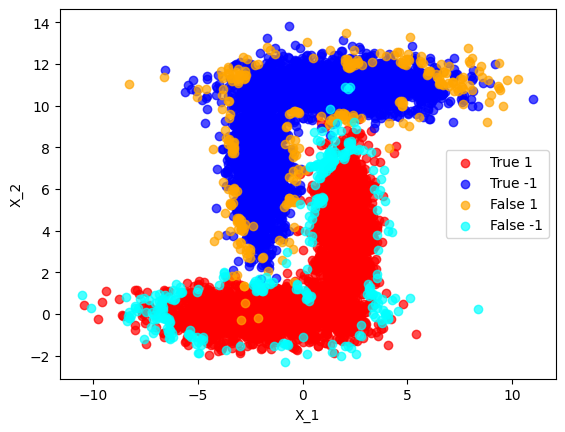

In [ ]:
miss_plot(y_lab_gd)

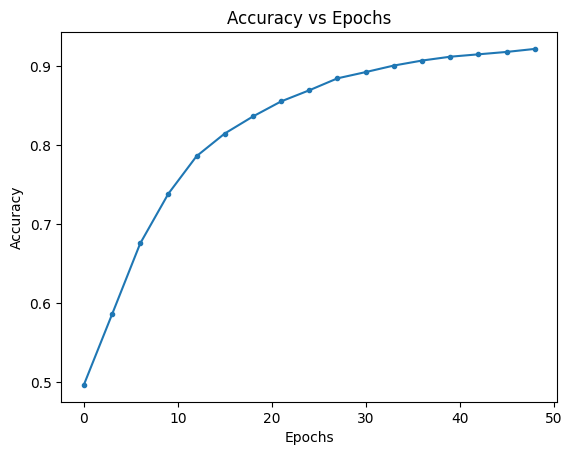

In [ ]:
acc_epochs_plot(acc_list_gd, check = check_gd)

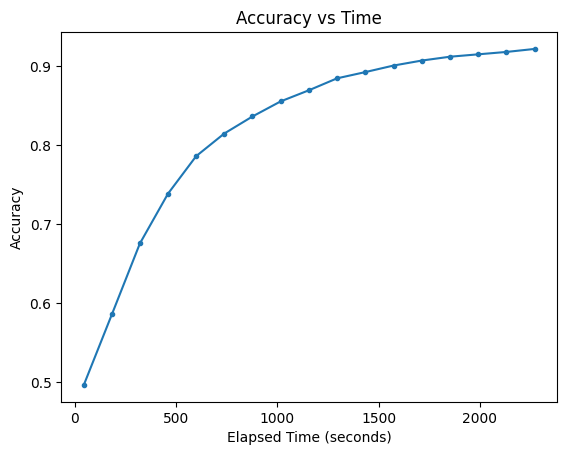

In [ ]:
acc_time_plot(acc_list_gd, time_list_gd)

### Randomized BCGD

In [ ]:
def rand_gradient(lab_samples, unlab_samples, ind_lab, W=w, W_bar=w_bar):
    grads = np.zeros(np.shape(unlab_samples)[0])
    j = np.random.randint(0, np.shape(unlab_samples)[0])
    j = int(j)
    grad = 0
    for i in range(np.shape(lab_samples)[0]):
        grad += W[j][i] * (unlab_samples[j][ind_lab] - lab_samples[i][ind_lab])
    for i in range(np.shape(unlab_samples)[0]):
        grad += W_bar[j][i] * (unlab_samples[j][ind_lab] - unlab_samples[i][ind_lab])
    grads[j] = 2 * grad 
    return grads

In [ ]:
def rand_bcgd(lab_samples, unlab_samples, ind_lab, alpha=1/L, epochs=epochs, epsilon=epsilon, check=check):
    y_lab = np.copy(unlab_samples)

    acc_list = []
    time_list = []

    start_time = time.process_time()

    for i in range(epochs):
        grads = rand_gradient(lab_samples, y_lab, ind_lab, w, w_bar)

        norm = np.linalg.norm(grads)
        if  norm < epsilon: 
          print(f"The norm of the gradient at iteration {i} is: {norm}")
          break

        y_lab[:, ind_lab] -= alpha * grads

        if(i % check == 0):
          print(f"The norm of the gradient at iteration {i} is: {norm}")
          acc_list.append(get_accuracy(y_lab[:,ind_lab]))
          elapsed_time = time.process_time() - start_time
          time_list.append(elapsed_time)

    return y_lab[:,ind_lab], acc_list, time_list

In [ ]:
epochs_random = 100000  # Customzied epochs constant for the Randomized BCGD algorithm
check_random = 5000     # Customzied check constant for the Randomized BCGD algorithm
epsilon_random = 1e-1000

In [ ]:
%%time
y_lab_rand_bcgd, acc_list_rand_bcgd, time_list_rand_bcgd = rand_bcgd(labeled_samples, random_unlabeled_samples, index_lab, epochs = epochs_random, check = check_random, epsilon = epsilon_random)

print(f"\nAccuracy for Randomized BCGD: {get_accuracy(y_lab_rand_bcgd)}")

print("\nFrequency of 1 in Randomized BCGD {}".format(np.sum(threshold_sel(y_lab_rand_bcgd) == 1) / len(y_lab_rand_bcgd)))
print("Frequency of -1 in Randomized BCGD {}\n".format(np.sum(threshold_sel(y_lab_rand_bcgd) == -1) / len(y_lab_rand_bcgd)))


The norm of the gradient at iteration 0 is: 3.8709963709760524
The norm of the gradient at iteration 5000 is: 12.40316368997276
The norm of the gradient at iteration 10000 is: 10.640574127528796
The norm of the gradient at iteration 15000 is: 9.17882666658303
The norm of the gradient at iteration 20000 is: 5.663800919939643
The norm of the gradient at iteration 25000 is: 1.793817392346171
The norm of the gradient at iteration 30000 is: 0.7288872791805365
The norm of the gradient at iteration 35000 is: 0.7925637866116055
The norm of the gradient at iteration 40000 is: 0.7875431307498794
The norm of the gradient at iteration 45000 is: 0.26961297818370167
The norm of the gradient at iteration 50000 is: 0.5207887715689311
The norm of the gradient at iteration 55000 is: 2.2139732092236737
The norm of the gradient at iteration 60000 is: 0.27264206338886715
The norm of the gradient at iteration 65000 is: 0.8973552304004058
The norm of the gradient at iteration 70000 is: 0.8244948015040398
The

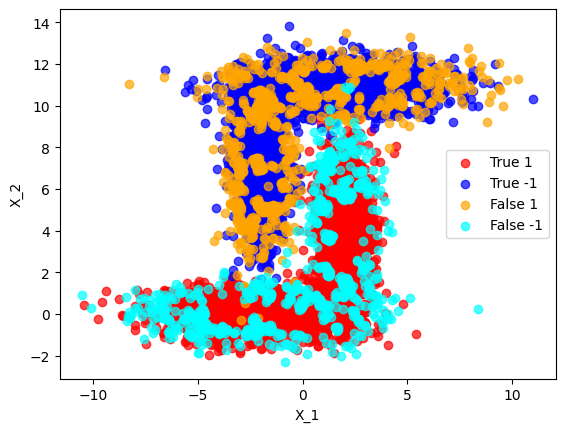

In [ ]:
miss_plot(y_lab_rand_bcgd)

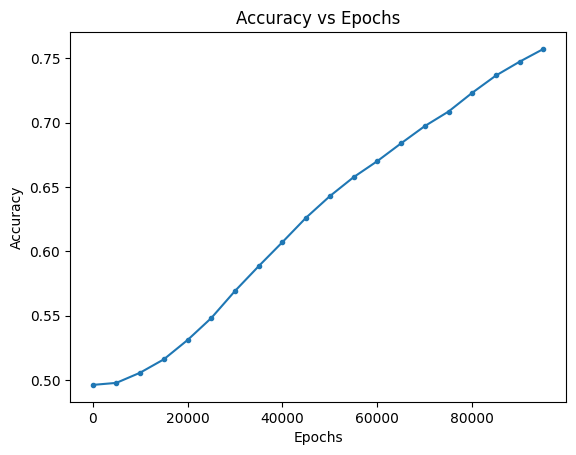

In [ ]:
acc_epochs_plot(acc_list_rand_bcgd, check = check_random)

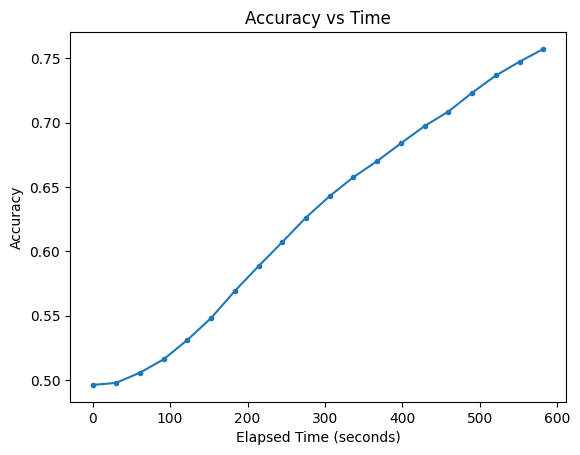

In [ ]:
acc_time_plot(acc_list_rand_bcgd, time_list_rand_bcgd)

### Gauss-Southwell BCGD

In [ ]:
def gs_gradient(lab_samples, unlab_samples, index, ind_lab, step_size, old_gradient, W=w, W_bar=w_bar):
  
  update = np.zeros(len(unlab_samples))
  grad = 0
  for i in range(np.shape(lab_samples)[0]):
    grad += W[index][i] * (unlab_samples[index][ind_lab] - lab_samples[i][ind_lab])
  for i in range(np.shape(unlab_samples)[0]):
    grad += W_bar[index][i] * (unlab_samples[index][ind_lab] - unlab_samples[i][ind_lab])
  
  update[index] = 2 * grad

  unlab_samples[:, ind_lab] += -step_size * update

  grad = 0
  for i in range(np.shape(lab_samples)[0]):
    grad += W[index][i] * (unlab_samples[index][ind_lab] - lab_samples[i][ind_lab])
  for i in range(np.shape(unlab_samples)[0]):
    grad += W_bar[index][i] * (unlab_samples[index][ind_lab] - unlab_samples[i][ind_lab])
  
  old_gradient[index] = 2 * grad 


  return unlab_samples[:,ind_lab], old_gradient

In [ ]:
def gs_bcgd(lab_samples, unlab_samples, ind_lab, alpha=1/L, epochs=epochs, epsilon=epsilon, check=check):
    y_lab = np.copy(unlab_samples)

    acc_list = []
    time_list = []

    start_time = time.process_time()

    grad = gradient(lab_samples, unlab_samples, ind_lab, w, w_bar)

    for i in range(epochs):

      norm = np.linalg.norm(grad)
      if  norm < epsilon:
        print(f"The norm of the gradient at iteration {i} is: {norm}") 
        break
      
      j = np.argmax(np.abs(grad))

      y_lab[:, ind_lab], grad = gs_gradient(lab_samples, y_lab, j, ind_lab, alpha, grad, w, w_bar)

      if(i % check == 0):
        print(f"The norm of the gradient at iteration {i} is: {norm}")
        acc_list.append(get_accuracy(y_lab[:,ind_lab]))
        elapsed_time = time.process_time() - start_time
        time_list.append(elapsed_time)

    return y_lab[:,ind_lab], acc_list, time_list

In [ ]:
epochs_gs = 100000  # Customzied epochs constant for the Randomized BCGD algorithm
check_gs = 5000     # Customzied check constant for the Randomized BCGD algorithm

In [ ]:
%%time
y_lab_gs_bcgd, y_list_gs_bcgd, time_list_gs_bcgd = gs_bcgd(labeled_samples, random_unlabeled_samples, index_lab, epochs = epochs_gs, check = check_gs)

print(f"\nAccuracy for Gauss-Southwell BCGD: {get_accuracy(y_lab_gs_bcgd)}")

print("\nFrequency of 1 in Gauss Sauthwell BCGD {}".format(np.sum(threshold_sel(y_lab_gs_bcgd) == 1) / len(y_lab_gs_bcgd)))
print("Frequency of -1 in Gauss Sauthwell BCGD {}\n".format(np.sum(threshold_sel(y_lab_gs_bcgd) == -1) / len(y_lab_gs_bcgd)))

The norm of the gradient at iteration 0 is: 1329.4177160088939
The norm of the gradient at iteration 5000 is: 626.231412450306
The norm of the gradient at iteration 10000 is: 419.60214890379757
The norm of the gradient at iteration 15000 is: 304.4077894188953
The norm of the gradient at iteration 20000 is: 232.3343449675606
The norm of the gradient at iteration 25000 is: 182.30554050383515
The norm of the gradient at iteration 30000 is: 145.88296896915043
The norm of the gradient at iteration 35000 is: 118.58239124541761
The norm of the gradient at iteration 40000 is: 97.67479080890321
The norm of the gradient at iteration 45000 is: 81.68310085262713
The norm of the gradient at iteration 50000 is: 68.76431595706235
The norm of the gradient at iteration 55000 is: 58.79069391593867
The norm of the gradient at iteration 60000 is: 50.62306399396044
The norm of the gradient at iteration 65000 is: 43.956055387661685
The norm of the gradient at iteration 70000 is: 38.546202472260916
The norm 

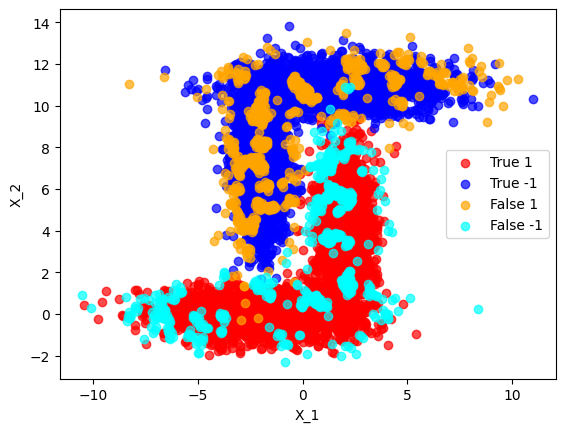

In [ ]:
miss_plot(y_lab_gs_bcgd)

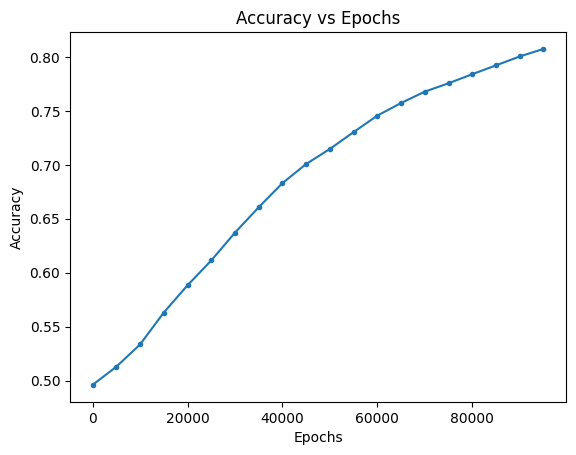

In [ ]:
acc_epochs_plot(y_list_gs_bcgd, check = check_gs)

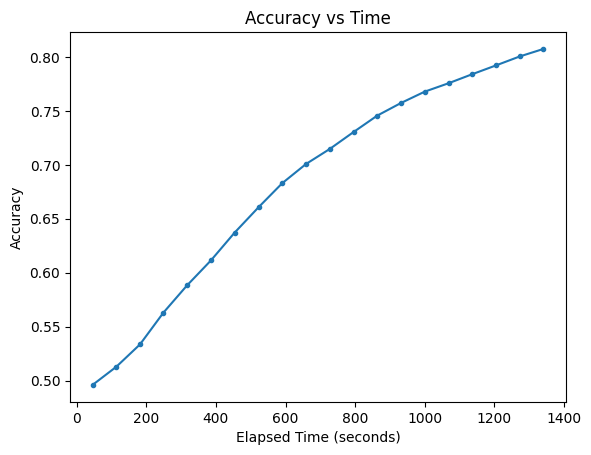

In [ ]:
acc_time_plot(y_list_gs_bcgd, time_list_gs_bcgd)

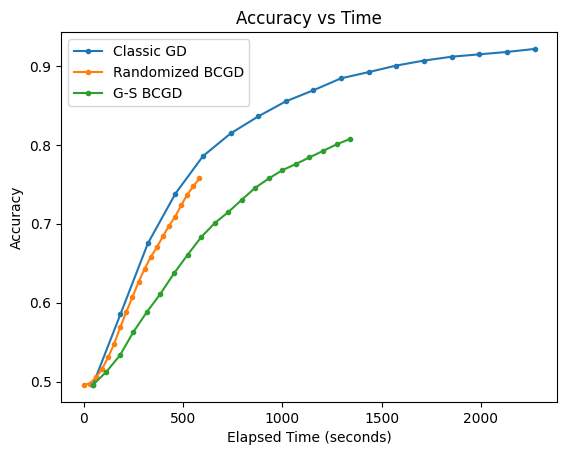

In [ ]:
acc_time_plot_global(acc_list_gd, time_list_gd, acc_list_rand_bcgd, time_list_rand_bcgd, y_list_gs_bcgd, time_list_gs_bcgd)

# Part 2

In [ ]:
# Download the dataset
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt

--2023-05-15 13:37:48--  https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46400 (45K) [application/x-httpd-php]
Saving to: ‘data_banknote_authentication.txt’

data_banknote_authe 100%[===================>]  45.31K   136KB/s    in 0.3s    

2023-05-15 13:37:49 (136 KB/s) - ‘data_banknote_authentication.txt’ saved [46400/46400]



In [ ]:
# Load the dataset into a Pandas DataFrame
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt', header=None, names=['variance', 'skewness', 'curtosis', 'entropy', 'class'])

# Normalize the features in the small set
scaler = MinMaxScaler()
df[['variance', 'skewness', 'curtosis', 'entropy']] = scaler.fit_transform(df[['variance', 'skewness', 'curtosis', 'entropy']])

# Replace 0 with -1 in the 'class' column
df['class'] = df['class'].replace(0, -1)

# Display the first few rows of the DataFrame
print(df.head())

   variance  skewness  curtosis   entropy  class
0  0.769004  0.839643  0.106783  0.736628     -1
1  0.835659  0.820982  0.121804  0.644326     -1
2  0.786629  0.416648  0.310608  0.786951     -1
3  0.757105  0.871699  0.054921  0.450440     -1
4  0.531578  0.348662  0.424662  0.687362     -1


In [ ]:
# 762 -1, 610 1 --> 45% class 1, 55% class -1
labels = np.array(df['class'].values)

In [ ]:
# Split the dataset into two sets, one with 5% of the examples and the other with 95% of the examples
large_set, small_set = train_test_split(df, test_size=0.05, stratify=df['class'])
print(f'Size of small set: {len(small_set)}')
print(f'Size of large set: {len(large_set)}')

Size of small set: 69
Size of large set: 1303


In [ ]:
true_unlabeled_samples = np.array(large_set['class'].values)

In [ ]:
# Set the class variable to 0 for all examples in the large set
large_set.loc[:, 'class'] = 0

In [ ]:
unlabeled_samples = large_set.to_numpy()
labeled_samples = small_set.to_numpy()

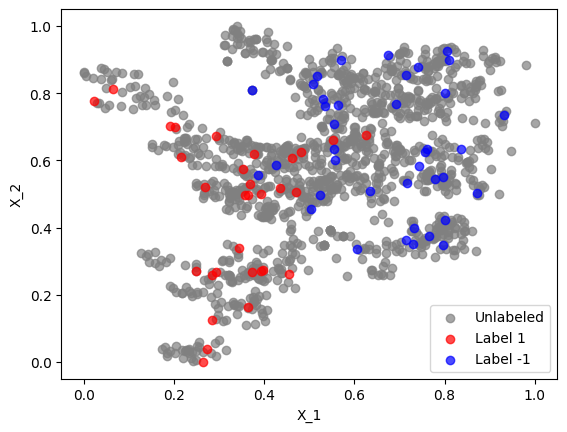

In [ ]:
plot_points(unlabeled_samples,labeled_samples[labeled_samples[:, -1] == 1], labeled_samples[labeled_samples[:, -1] == -1])

In [ ]:
index_lab = 4
random_unlabeled_samples = generate_random_labels(unlabeled_samples, index_lab)

In [ ]:
weights = similarity_matrix(unlabeled_samples, labeled_samples, index_lab)
w=weights[0]
w_bar=weights[1]

In [ ]:
L = compute_L(unlabeled_samples, w, w_bar)
print(L)

204.1999186385567


In [ ]:
# CLASSIC GRADIENT
epsilon = 1e-5      # Threshold for the stopping condition
epochs = 100        # Max number of iterations
check_gd = 5           # Used to retrieve informations about the behavior of the algorithm every check iterations

In [ ]:
%%time
y_lab_gd, acc_list_gd, time_list_gd = gradient_descent(labeled_samples, random_unlabeled_samples, index_lab, alpha=1/L, check = check_gd, epochs = epochs, epsilon = epsilon)

print(f"\nAccuracy for Gradient Descent: {get_accuracy(y_lab_gd)}")

print("\nNumber of 1 in Gradient Descent {}".format(np.sum(threshold_sel(y_lab_gd) == 1) / len(y_lab_gd)))
print("Number of -1 in Gradient Descent {}\n".format(np.sum(threshold_sel(y_lab_gd) == -1) / len(y_lab_gd)))

The norm of the gradient at iteration 0 is: 4161.300898107589
The norm of the gradient at iteration 5 is: 271.2239545389891
The norm of the gradient at iteration 10 is: 124.95036625418446
The norm of the gradient at iteration 15 is: 79.64880203083482
The norm of the gradient at iteration 20 is: 57.44348596971616
The norm of the gradient at iteration 25 is: 44.273957966207874
The norm of the gradient at iteration 30 is: 35.5372845781682
The norm of the gradient at iteration 35 is: 29.293885061292926
The norm of the gradient at iteration 40 is: 24.59791846377024
The norm of the gradient at iteration 45 is: 20.938058403952507
The norm of the gradient at iteration 50 is: 18.013541747547844
The norm of the gradient at iteration 55 is: 15.634045208384595
The norm of the gradient at iteration 60 is: 13.6714022377733
The norm of the gradient at iteration 65 is: 12.034844879370315
The norm of the gradient at iteration 70 is: 10.65755844558876
The norm of the gradient at iteration 75 is: 9.48894

In [ ]:
# RANDOMIZED BCGD
epochs_random = 200000  # Customzied epochs constant for the Randomized BCGD algorithm
check_random = 10000     # Customzied check constant for the Randomized BCGD algorithm

In [ ]:
%%time
y_lab_rand_bcgd, acc_list_rand_bcgd, time_list_rand_bcgd = rand_bcgd(labeled_samples, random_unlabeled_samples, index_lab, alpha=1/L, epochs = epochs_random, check = check_random, epsilon = epsilon)

print(f"\nAccuracy for Randomized BCGD: {get_accuracy(y_lab_rand_bcgd)}")

print("\nFrequency of 1 in Randomized BCGD {}".format(np.sum(threshold_sel(y_lab_rand_bcgd) == 1) / len(y_lab_rand_bcgd)))
print("Frequency of -1 in Randomized BCGD {}\n".format(np.sum(threshold_sel(y_lab_rand_bcgd) == -1) / len(y_lab_rand_bcgd)))

The norm of the gradient at iteration 0 is: 93.9548477274105
The norm of the gradient at iteration 10000 is: 2.783755789347289
The norm of the gradient at iteration 20000 is: 3.516082578891251
The norm of the gradient at iteration 30000 is: 1.8647558217012377
The norm of the gradient at iteration 40000 is: 0.6870966815807484
The norm of the gradient at iteration 50000 is: 0.0664236198607885
The norm of the gradient at iteration 60000 is: 0.4863407038800067
The norm of the gradient at iteration 70000 is: 0.1932877234468889
The norm of the gradient at iteration 80000 is: 2.025789122182514
The norm of the gradient at iteration 90000 is: 0.08065296633065325
The norm of the gradient at iteration 100000 is: 0.35786116876847357
The norm of the gradient at iteration 110000 is: 0.06425293570803842
The norm of the gradient at iteration 120000 is: 0.22790478399434058
The norm of the gradient at iteration 130000 is: 0.20192369603443117
The norm of the gradient at iteration 140000 is: 0.03661024661

In [ ]:
# G-S BCGD
epochs_gs = 50000  # Customzied epochs constant for the Randomized BCGD algorithm
check_gs = 2500    # Customzied check constant for the Randomized BCGD algorithm

In [ ]:
%%time
y_lab_gs_bcgd, acc_list_gs_bcgd, time_list_gs_bcgd = gs_bcgd(labeled_samples, random_unlabeled_samples, index_lab, alpha=1/L, epochs = epochs_gs, check = check_gs, epsilon = epsilon)

print(f"\nAccuracy for Gauss-Southwell BCGD: {get_accuracy(y_lab_gs_bcgd)}")

print("\nFrequency of 1 in Gauss Sauthwell BCGD {}".format(np.sum(threshold_sel(y_lab_gs_bcgd) == 1) / len(y_lab_gs_bcgd)))
print("Frequency of -1 in Gauss Sauthwell BCGD {}\n".format(np.sum(threshold_sel(y_lab_gs_bcgd) == -1) / len(y_lab_gs_bcgd)))

The norm of the gradient at iteration 0 is: 4161.300898107589
The norm of the gradient at iteration 2500 is: 734.3069907716495
The norm of the gradient at iteration 5000 is: 293.37393941705875
The norm of the gradient at iteration 7500 is: 124.03078833350075
The norm of the gradient at iteration 10000 is: 57.481700097013814
The norm of the gradient at iteration 12500 is: 30.58828947441671
The norm of the gradient at iteration 15000 is: 18.765504164396994
The norm of the gradient at iteration 17500 is: 12.851414101230167
The norm of the gradient at iteration 20000 is: 9.419384683159302
The norm of the gradient at iteration 22500 is: 7.246474084364008
The norm of the gradient at iteration 25000 is: 5.723905520778657
The norm of the gradient at iteration 27500 is: 4.7077514852388225
The norm of the gradient at iteration 30000 is: 3.9797108045017984
The norm of the gradient at iteration 32500 is: 3.403068326574845
The norm of the gradient at iteration 35000 is: 2.954730881055773
The norm o

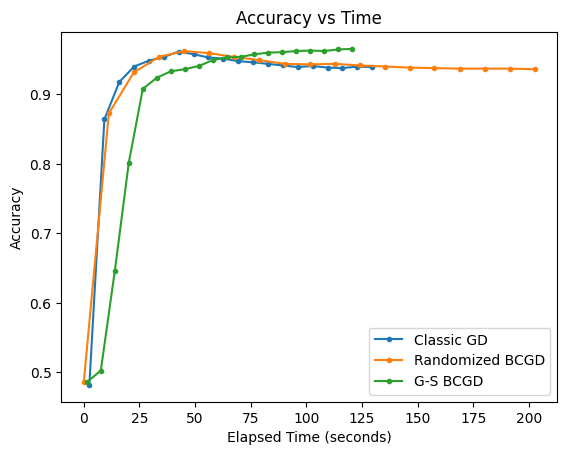

In [ ]:
acc_time_plot_global(acc_list_gd, time_list_gd, acc_list_rand_bcgd, time_list_rand_bcgd, acc_list_gs_bcgd, time_list_gs_bcgd) 